In [6]:
# @title MLP
import numpy as np


class LinearLayer:


    def __init__(self, input_size, output_size):

        '''
        input_size: int; size of input
        output_size: int; size of output
        activation_fn: str; type of activation function for the layer
        '''

        self.weights = np.random.randn(input_size, output_size)/10. # shape (input, output)
        self.weights_grads = np.empty_like(self.weights) #shape (input, output)
        self.biases = np.random.randn(output_size)/10. # shape (output, )
        self.biases_grads = np.empty_like(self.biases) # shape (output, )

        self.activation_function = self.ReLU
        self.activation_function_gradient = self.ReLU_backward

    def forward(self, x):
        '''Forward pass'''
        self.x = x
        self.value = np.matmul(x, self.weights) + self.biases
        self.activation_value = self.activation_function(self.value)
        return self.activation_value

    def backward(self, output_grad):
        '''Backpropagation'''
        activation_grad = self.activation_function_gradient(output_grad)
        self.biases_grads = activation_grad.reshape(self.biases_grads.shape)
        self.weights_grads = np.matmul(self.x.T, activation_grad)
        return np.matmul(activation_grad, self.weights.T)

    def step(self, learning_rate=1e-3):
        '''Learning rate application'''
        self.weights -= self.weights_grads * learning_rate
        self.biases -= self.biases_grads * learning_rate

    def ReLU(self, x):
        '''Relu activation function'''
        return np.maximum(0, x)

    def ReLU_backward(self, output_grad):
        '''Relu activation function backpropagation'''
        return output_grad * (self.activation_value > 0).astype(float)

import functools
from collections import defaultdict

def accuracy_score(y_true, y_pred):
    return np.mean(y_true == y_pred)

def balanced_accuracy_score(y_true, y_pred):
    classes = np.unique(y_true)
    class_accuracies = []
    for c in classes:
        true_mask = (y_true == c)
        pred_mask = (y_pred == c)
        class_accuracy = np.mean(y_true[true_mask] == y_pred[true_mask])
        class_accuracies.append(class_accuracy)
    return np.mean(class_accuracies)

def precision_score(y_true, y_pred, average='macro'):
    classes = np.unique(y_true)
    precisions = []
    for c in classes:
        true_mask = (y_true == c)
        pred_mask = (y_pred == c)
        true_positive = np.sum(y_true[true_mask] == y_pred[true_mask])
        false_positive = np.sum(y_pred[pred_mask] != y_true[pred_mask])
        if (true_positive + false_positive) == 0:
            precision = 0
        else:
            precision = true_positive / (true_positive + false_positive)
        precisions.append(precision)
    if average == 'macro':
        return np.mean(precisions)
    elif average == 'micro':
        return np.sum(precisions) / len(classes)

def recall_score(y_true, y_pred, average='macro'):
    classes = np.unique(y_true)
    recalls = []
    for c in classes:
        true_mask = (y_true == c)
        pred_mask = (y_pred == c)
        true_positive = np.sum(y_true[true_mask] == y_pred[true_mask])
        false_negative = np.sum(y_pred[true_mask] != y_true[true_mask])
        if (true_positive + false_negative) == 0:
            recall = 0
        else:
            recall = true_positive / (true_positive + false_negative)
        recalls.append(recall)
    if average == 'macro':
        return np.mean(recalls)
    elif average == 'micro':
        return np.sum(recalls) / len(classes)

class MLPClassifier:

    '''
    MLP multiclass classifier with an arbitrary number
     of fully connected linear layers and softmax cross-entropy loss function
    '''

    def __init__(self, input_size, output_size, n_layers,
                 layer_dims):

        '''
        Arguments:
            input_size: (int): size of 1 instance of data (X)

            output_size: (int): size of the prediction vector

            n_layers: (int): number of layers in the network

            layer_dims: list[int]: dimensions of hidden layers,
            (len(layer_dims) = n_layers - 1)
        '''


        layer_dims = [input_size] + layer_dims + [output_size]

        self.layers = [LinearLayer(layer_dims[i], layer_dims[i + 1])
                                   for i in range(n_layers)]

        self.layers[-1].activation_function = lambda x: x
        self.layers[-1].activation_function_gradient = lambda x: x

        self.loss_function = self.softmax_crossentropy
        self.loss_function_grad = self.grad_softmax_crossentropy

        self.metrics = defaultdict(list)

        self.trained = False

    def forward(self, x):
        '''Forward pass'''
        layers = [functools.partial(layer.forward) for layer in self.layers]
        return functools.reduce((lambda x, y: y(x)), layers, x)

    def backward(self, output_grad):
        '''Backpropagation'''
        layer_grads = [functools.partial(layer.backward)
                       for layer in self.layers[::-1]]
        return functools.reduce((lambda x, y: y(x)), layer_grads, output_grad)

    def softmax_crossentropy(self, y, ygt):
        '''Softmax activation and cross-entropy loss'''
        softmax = np.exp(y) / (np.exp(y).sum() + 1e-6)
        return -np.log(softmax[0, ygt] + 1e-6)[0]

    def grad_softmax_crossentropy(self, y, ygt):
        '''Softmax activation and cross-entropy loss backpropagation'''
        softmax = np.exp(y) / (np.exp(y).sum() + 1e-6)
        softmax[0, ygt] -= 1
        return softmax

    def step(self, learning_rate):
        '''Application of learning rate'''
        for layer in self.layers:
            layer.step(learning_rate)

    def fit(self, X_train, y_train, learning_rate=1e-3,
            n_epochs=20, show_progress=True):
        '''Training routine'''
        train_size = X_train.shape[0]

        if show_progress == True:
            show_progress = 1

        for epoch in range(1, n_epochs + 1):
            y_pred = []
            running_loss = []

            for sample in range(train_size):
                x = X_train[sample].reshape((1, -1))

                ygt_i = np.array([y_train[sample]])
                y_i = self.forward(x)

                loss = self.loss_function(y_i, ygt_i)
                loss_grad = self.loss_function_grad(y_i, ygt_i)
                running_loss.append(loss)

                self.backward(loss_grad)
                self.step(learning_rate)
                y_pred.extend(y_i.argmax(1))

            self.metrics['accuracy'].append(accuracy_score(y_train, y_pred))
            self.metrics['balanced accuracy'].append(balanced_accuracy_score(y_train, y_pred))
            self.metrics['recall'].append(recall_score(y_train, y_pred, average='micro'))
            self.metrics['precision'].append(precision_score(y_train, y_pred, average='micro'))
            self.metrics['loss'].append(np.mean(running_loss))

            if show_progress and epoch % show_progress == 0:
                print(f'Epoch: {epoch}/{n_epochs}\tloss: {np.mean(running_loss):.3f}\t',\
                      f'balanced accuracy on train: {balanced_accuracy_score(y_train, y_pred):.3f}')

        self.trained = True

    def predict(self, X_test):
        '''Forward pass that returns predictions from test data'''
        assert self.trained, 'The network was never trained'
        y_pred = []
        for sample in X_test:
            X_i = sample.reshape((1, -1))
            y_i = self.forward(X_i)
            y_pred.extend(y_i.argmax(1))
        return np.array(y_pred)

In [16]:
# @title Plotting

class PlotMetrics:
    def __init__(self, model):

        self.model = model

    def plot(self):
        '''Plot metrics'''
        n_metrics = len(self.model.metrics)
        fig, ax = plt.subplots(n_metrics, 1, figsize=(10, 3.5*n_metrics))
        fig.tight_layout(pad=5)
        for i, metric in enumerate(self.model.metrics):
            n_epochs = len(self.model.metrics[metric])
            ax[i].plot(range(1, n_epochs + 1), self.model.metrics[metric], color='k')
            ax[i].axhline(self.model.metrics[metric][-1], linestyle='--', color='g')
            ax[i].set_title(metric)
            ax[i].set_xlabel('epoch')

In [14]:
# @title Data loading
import numpy as np
import matplotlib.pyplot as plt
data = np.load('/content/drive/MyDrive/PRNN/Assignment3/animals10/animals10_data.npz')
# Load the data from the .npz file
image_data = np.load('/content/drive/MyDrive/PRNN/Assignment3/animals10/animals10pca_data.npz')
image_data=image_data['data']
print(np.shape(image_data))

# Extract images and labels
labels = data['labels']
num_classes = len(np.unique(labels))
print(num_classes)
# Define the sizes for training, validation, and testing sets
train_size = int(0.6 * len(image_data))
val_size = int(0.2 * len(image_data))
test_size = len(image_data) - train_size - val_size

# Shuffle the data
indices = np.random.permutation(len(image_data))
image_data_shuffled = image_data[indices]
labels_shuffled = labels[indices]

# Split the data into training, validation, and testing sets
x_train = image_data_shuffled[:train_size]
y_train = labels_shuffled[:train_size].astype(int)
y_train=y_train.reshape(-1,1)

x_val = image_data_shuffled[train_size:train_size+val_size]
y_val = labels_shuffled[train_size:train_size+val_size].astype(int)
y_val=y_val.reshape(-1,1)

x_test = image_data_shuffled[train_size+val_size:]
y_test = labels_shuffled[train_size+val_size:].astype(int)
y_test=y_test.reshape(-1,1)


def min_max_normalize(X):
    min_vals = X.min(axis=0)
    max_vals = X.max(axis=0)
    X_normalized = (X - min_vals) / (max_vals - min_vals)
    return X_normalized

x_train_normalized = min_max_normalize(x_train)
x_test_normalized = min_max_normalize(x_test)
x_val_normalized = min_max_normalize(x_val)


# Print the shapes of the split sets
print("Shape of x_train:", x_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of x_val:", x_val.shape)
print("Shape of y_val:", y_val.shape)
print("Shape of x_test:", x_test.shape)
print("Shape of y_test:", y_test.shape)

# Convert labels to one-hot encoded vectors
y_train_one_hot = np.eye(num_classes)[y_train]
y_val_one_hot = np.eye(num_classes)[y_val]
y_test_one_hot = np.eye(num_classes)[y_test]
print(np.max(x_train_normalized))

(26179, 551)
10
Shape of x_train: (15707, 551)
Shape of y_train: (15707, 1)
Shape of x_val: (5235, 551)
Shape of y_val: (5235, 1)
Shape of x_test: (5237, 551)
Shape of y_test: (5237, 1)
1.0


In [12]:
input_size = x_train.shape[1]
output_size = 10
layer_dims = [100, 350, 500]
n_layers = len(layer_dims) + 1
n_epochs = 20
learning_rate = 1e-3

In [15]:
mlp = MLPClassifier(input_size=input_size, output_size=output_size,
                    n_layers=n_layers, layer_dims=layer_dims)
mlp.fit(x_train, y_train, n_epochs=n_epochs,
        learning_rate=learning_rate)

Epoch: 1/20	loss: 2.143	 balanced accuracy on train: 0.197
Epoch: 2/20	loss: 1.862	 balanced accuracy on train: 0.275
Epoch: 3/20	loss: 1.729	 balanced accuracy on train: 0.327
Epoch: 4/20	loss: 1.615	 balanced accuracy on train: 0.375
Epoch: 5/20	loss: 1.507	 balanced accuracy on train: 0.421
Epoch: 6/20	loss: 1.398	 balanced accuracy on train: 0.470
Epoch: 7/20	loss: 1.288	 balanced accuracy on train: 0.520
Epoch: 8/20	loss: 1.178	 balanced accuracy on train: 0.568
Epoch: 9/20	loss: 1.065	 balanced accuracy on train: 0.618
Epoch: 10/20	loss: 0.954	 balanced accuracy on train: 0.665
Epoch: 11/20	loss: 0.841	 balanced accuracy on train: 0.718
Epoch: 12/20	loss: 0.733	 balanced accuracy on train: 0.766
Epoch: 13/20	loss: 0.628	 balanced accuracy on train: 0.809
Epoch: 14/20	loss: 0.531	 balanced accuracy on train: 0.849
Epoch: 15/20	loss: 0.443	 balanced accuracy on train: 0.885
Epoch: 16/20	loss: 0.362	 balanced accuracy on train: 0.915
Epoch: 17/20	loss: 0.297	 balanced accuracy on tr

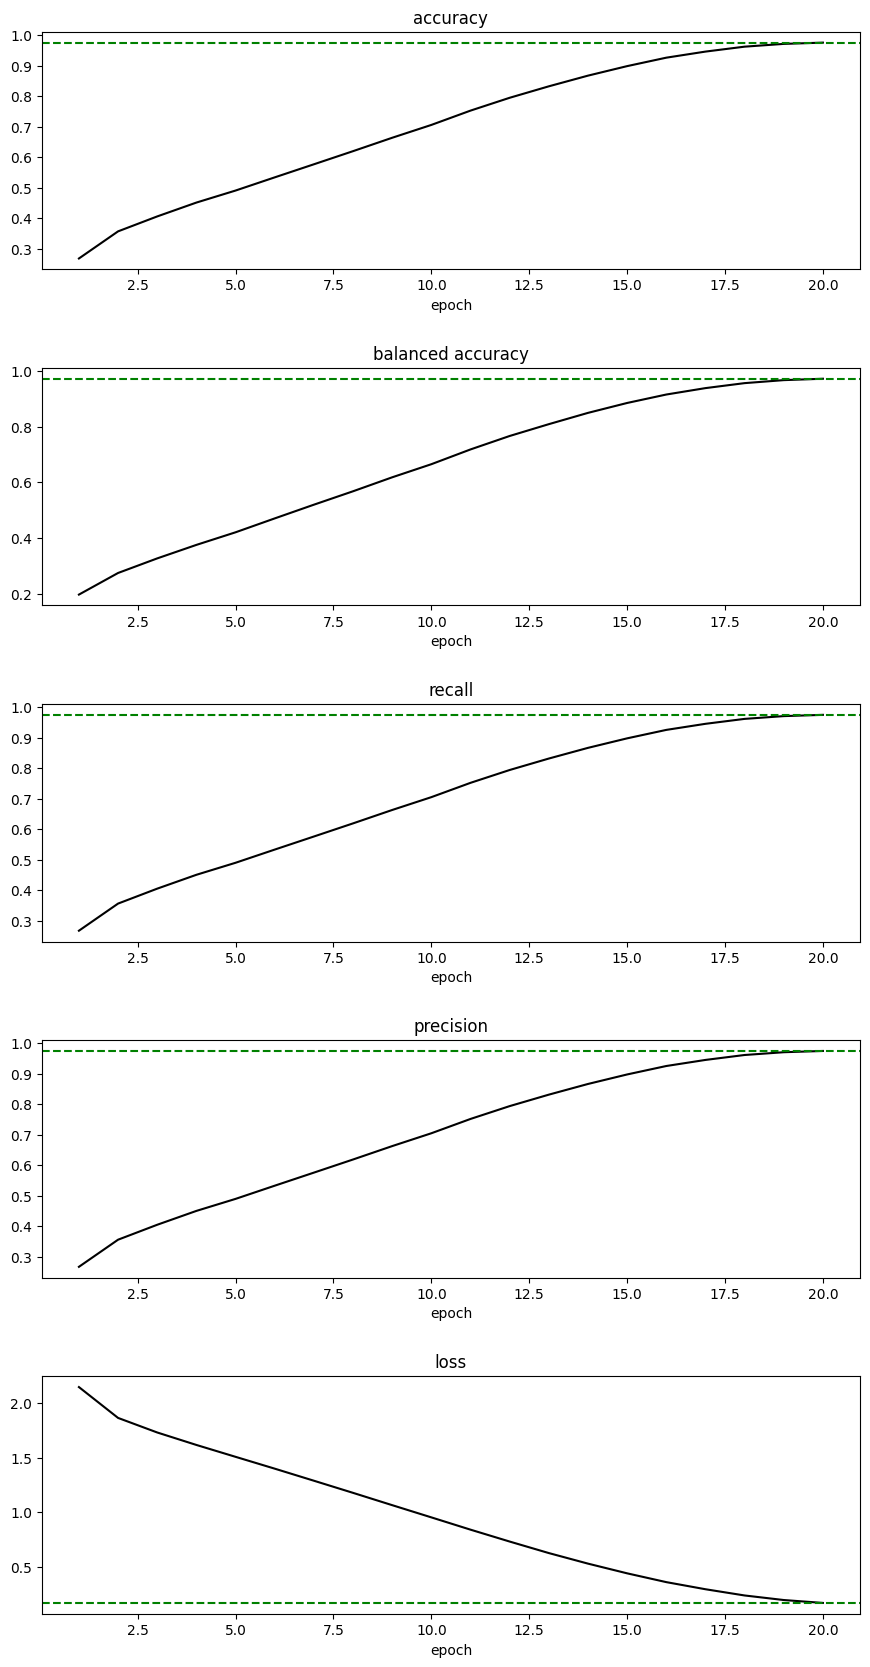

In [17]:
PlotMetrics(mlp).plot()
